## 📦 **Import Libraries**

In [1]:
!pip install Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 16.3 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings('ignore')

# mount drive
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import re, string

import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from wordcloud import WordCloud

# from googletrans import Translator
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

Mounted at /content/drive


## 🗃️ **Data Preparation**

In [3]:
dir = '/content/drive/MyDrive/Colab Notebooks/ml-stuff/data/'

services = pd.read_csv(dir + 'services_preprocessed_re.csv')
projects = pd.read_csv(dir + 'projects_preprocessed_minimum.csv')

kamus_alay = pd.read_csv('https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv')
# kamus_alay = pd.read_csv(dir + 'colloquial-indonesian-lexicon.csv')
kamus_alay = kamus_alay.filter(['slang', 'formal'], axis = 1).drop_duplicates(subset = ['slang'])
kamus_alay_map = dict(zip(kamus_alay['slang'], kamus_alay['formal']))

#### 📂 **Dataset Information**

In [4]:
projects.head(2)

,Unnamed: 0,text_clean,finishDays,tags_token,budget
0,0,penulis yang tinggal di apartemen jakarta menu...,7.0,['Writing'],250000.0
1,1,membuat artikel di media online pekerjaan memb...,7.0,"['Blog', 'Blogspot', 'Content Management Syste...",350000.0


In [5]:
services.head(2)

,Unnamed: 0,text_clean,workDuration,tags_token,fixedFee
0,0,saya bisa membuat sistem dan tampilan website ...,30.0,"['Web Programming', 'PHP', 'Website', 'Wordpre...",650000
1,1,kesusahan slicing design mobile apps atau meng...,3.0,"['Java', 'Mobile Programming', 'Windows Mobile...",200000


## 📊 **Exploratory Data Analysis**

### **Missing Values Overview**

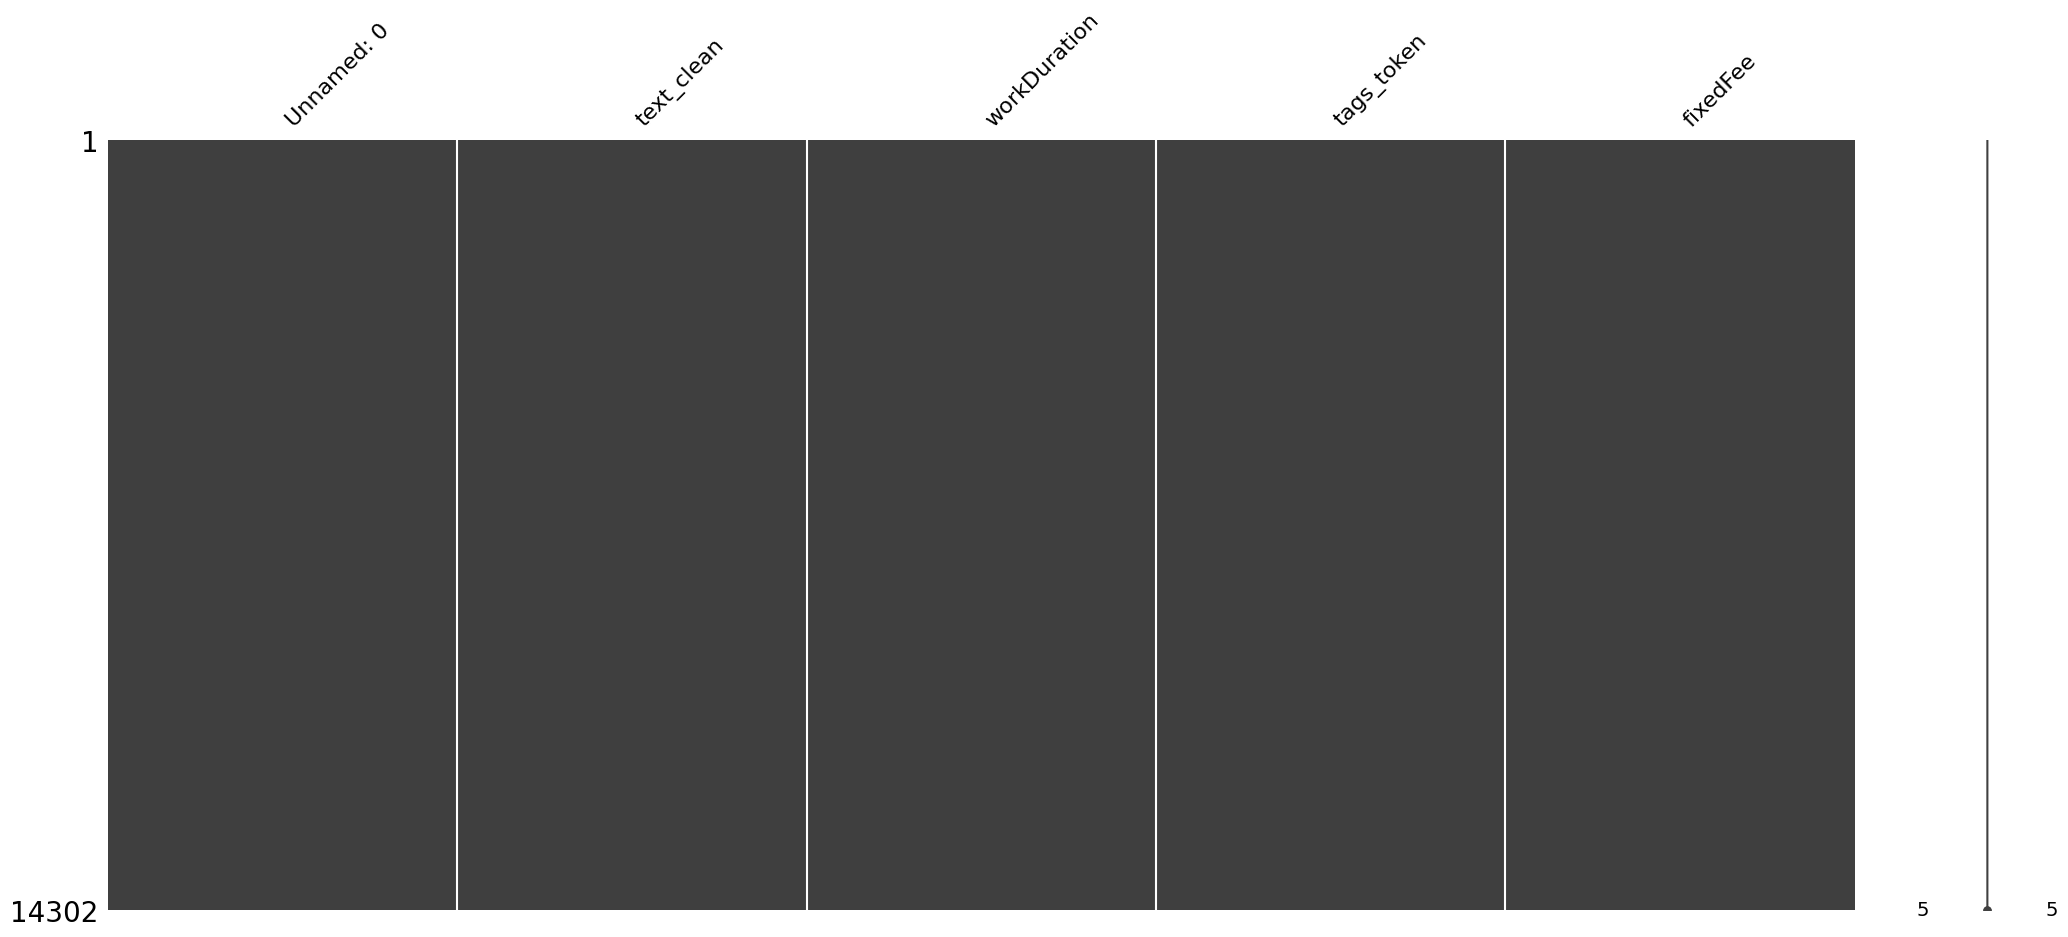

In [6]:
msno.matrix(services)
plt.show()

In [7]:
round(services.isna().mean().sort_values(ascending = False), 4)

Unnamed: 0      0.0
text_clean      0.0
workDuration    0.0
tags_token      0.0
fixedFee        0.0
dtype: float64

In [8]:
df_services = services
df_projects = projects

In [9]:
df_services.head(2)

,Unnamed: 0,text_clean,workDuration,tags_token,fixedFee
0,0,saya bisa membuat sistem dan tampilan website ...,30.0,"['Web Programming', 'PHP', 'Website', 'Wordpre...",650000
1,1,kesusahan slicing design mobile apps atau meng...,3.0,"['Java', 'Mobile Programming', 'Windows Mobile...",200000


In [10]:
df_projects.head(2)

,Unnamed: 0,text_clean,finishDays,tags_token,budget
0,0,penulis yang tinggal di apartemen jakarta menu...,7.0,['Writing'],250000.0
1,1,membuat artikel di media online pekerjaan memb...,7.0,"['Blog', 'Blogspot', 'Content Management Syste...",350000.0


In [11]:
df_services.rename(columns = {'tags_token':'service_tags'}, inplace = True)
df_services.rename(columns = {'text_clean':'text'}, inplace = True)
df_services.drop('Unnamed: 0', axis = 1, inplace = True)

In [12]:
df_projects.rename(columns = {'tags_token':'projects_tags'}, inplace = True)
df_projects.rename(columns = {'text_clean':'text'}, inplace = True)
df_projects.drop('Unnamed: 0', axis = 1, inplace = True)

##`project_tags`

In [13]:
# Filtering the rare terms.
df_services = df_services.groupby("service_tags").filter(lambda x: len(x) > 1)
df_services['service_tags']

2        ['Advertising', 'Design Arts', 'Brochure', 'Gr...
5                     ['Search Engine Optimization (SEO)']
6                                              ['Youtube']
13                    ['Search Engine Optimization (SEO)']
16                                             ['Website']
                               ...                        
14291                    ['Advertising', 'Google Adwords']
14292                                          ['Android']
14293                                       ['Copywriter']
14297    ['Website', 'Wordpress', 'Web Design', 'Websit...
14300                           ['Translation', 'Writing']
Name: service_tags, Length: 6947, dtype: object

In [14]:
# Filtering the rare terms.
df_projects = df_projects.groupby("projects_tags").filter(lambda x: len(x) > 1)
df_projects['projects_tags']

0                                              ['Writing']
3        ['Design Arts', 'Graphic Design', 'Logo Design...
4                                           ['iPhone/iOS']
5                                              ['Writing']
6                 ['Data Entry', 'Quesioner', 'Responden']
                               ...                        
39221                                  ['Email Marketing']
39222                                          ['English']
39224                                   ['Graphic Design']
39225                                  ['Adobe PhotoShop']
39226                     ['CorelDRAW', 'Adobe PhotoShop']
Name: projects_tags, Length: 27838, dtype: object

In [15]:
import ast 

df_services['service_tags'] = [ast.literal_eval(i) for i in df_services['service_tags']]
df_services['service_tags'].values[:5]

array([list(['Advertising', 'Design Arts', 'Brochure', 'Graphic Design', 'Logo Design', 'Adobe PhotoShop', 'Adobe Illustrator', 'Multimedia', 'PIC', 'Instagram', 'Infogram']),
       list(['Search Engine Optimization (SEO)']), list(['Youtube']),
       list(['Search Engine Optimization (SEO)']), list(['Website'])],
      dtype=object)

In [16]:
import ast 

df_projects['projects_tags'] = [ast.literal_eval(i) for i in df_projects['projects_tags']]
df_projects['projects_tags'].values[:5]

array([list(['Writing']),
       list(['Design Arts', 'Graphic Design', 'Logo Design', 'Canva']),
       list(['iPhone/iOS']), list(['Writing']),
       list(['Data Entry', 'Quesioner', 'Responden'])], dtype=object)

In [17]:
df_services['text'] = df_services['text'].astype(str)
df_projects['text'] = df_projects['text'].astype(str)

## Base Model

In [18]:
from sklearn.model_selection import train_test_split

test_split = 0.1

# Initial train and test split.
projects_train_df, projects_test_df = train_test_split(
    df_projects,
    test_size=test_split,
    stratify=df_projects["projects_tags"].values,
)

# Splitting the test set further into validation
# and new test sets.
projects_val_df = projects_test_df.sample(frac=0.5)
projects_test_df.drop(projects_val_df.index, inplace=True)

print(f"Number of rows in training set: {len(projects_train_df)}")
print(f"Number of rows in validation set: {len(projects_val_df)}")
print(f"Number of rows in test set: {len(projects_test_df)}")

Number of rows in training set: 25054
Number of rows in validation set: 1392
Number of rows in test set: 1392


In [19]:
from sklearn.model_selection import train_test_split

test_split = 0.2

# Initial train and test split.
services_train_df, services_test_df = train_test_split(
    df_services,
    test_size=test_split,
    stratify=df_services["service_tags"].values,
)

# Splitting the test set further into validation
# and new test sets.
services_val_df = services_test_df.sample(frac=0.5)
services_test_df.drop(services_val_df.index, inplace=True)

print(f"Number of rows in training set: {len(services_train_df)}")
print(f"Number of rows in validation set: {len(services_val_df)}")
print(f"Number of rows in test set: {len(services_test_df)}")

Number of rows in training set: 5557
Number of rows in validation set: 695
Number of rows in test set: 695


In [20]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

In [21]:
terms = tf.ragged.constant(services_train_df["service_tags"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', 'Adobe PhotoShop', 'Graphic Design', 'Adobe Illustrator', 'Writing', 'Website', 'CorelDRAW', 'Logo Design', 'Website Building', 'Data Entry', 'Wordpress', 'Social Media Marketing (SMM)', 'Web Design', 'Translation', 'Search Engine Optimization (SEO)', 'Website Templates', 'Design Arts', 'Web Programming', 'Internet Marketing', 'PHP', 'Content Writer', 'Microsoft Word', 'Copywriter', 'Video Editing', 'Wordpress Templates', 'Video Production', 'Photography', 'Instagram', 'Microsoft Excel', 'Accounting', 'Advertising', 'Illustration', 'MySQL', 'Blog', 'Android', 'English', 'Tax Consultation', 'Retyping', 'Vector Graphics', 'Marketing Strategy', 'Blogspot', 'Adobe Premiere', 'Sales and Marketing', 'Youtube', 'CodeIgniter', '3D Modelling', 'Microsoft PowerPoint', 'HTML', '3D Architecture', 'Adobe After Effects', 'Microsoft Office', 'Data Analysis', 'Business Document Translation', 'Adobe Indesign', '3D Rendering', 'Web Research', 'Laravel Framework', 'Audio Editing', 

In [23]:
sample_label = services_train_df["service_tags"].iloc[250]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['Data Entry']
Label-binarized representation: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]


In [24]:
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["service_tags"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["text"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [25]:
projects_val_df.rename(columns = {'projects_tags':'service_tags'}, inplace = True)
projects_test_df.rename(columns = {'projects_tags':'service_tags'}, inplace = True)

In [26]:
train_dataset = make_dataset(services_train_df, is_train=True)
validation_dataset = make_dataset(projects_val_df, is_train=False)
test_dataset = make_dataset(projects_test_df, is_train=False)

In [27]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Text: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Text: b'menganalisa transaksi menjurnal membuat chart of account dan menyajikan laporan keuangan sesuai dengan standar akuntansi keuangan menganalisa jenis pajak yang terjadi dalam setiap transaksi menghitung pajak terutang memperhitungkan dengan kredit pajak untuk diperoleh pajak yang sesuai dengan peraturan perundang undangan pajak'
Label(s): ['Accounting' 'Tax Consultation']
 
Text: b'bimbingan penulisan jurnal ilmiah internasional terindeks sinta dikti pada bidang kesehatan kedokteran dan farmasi bimbingan dari awal pemilihan topik penulisan pemilihan jurnal yang akan di apply sampai dengan manuskrip penulisan selesai'
Label(s): ['Writing' 'Proofreading']
 
Text: b'ayo buruan desain murah dan insyaallah berkualitas 5 hari maksimal jadi 10 hari belum jadi bisa cabut sekali deal langsung saya kerjain desain mulai dari 1000 sampai 60 000'
Label(s): ['Adobe PhotoShop']
 
Text: b'halo butuh artikel artikel untuk mengisi website atau blog anda maupun untuk kebutuhan lainnya saya menawark

In [30]:
vocabulary = set()
services_train_df["text"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

17516


In [29]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

In [31]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [   layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model

In [32]:
epochs = 20

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)

Epoch 1/20
44/44 [==============================] - 7s 30ms/step - loss: 0.1480 - binary_accuracy: 0.9535 - val_loss: 0.0534 - val_binary_accuracy: 0.9913
Epoch 2/20
44/44 [==============================] - 2s 34ms/step - loss: 0.0272 - binary_accuracy: 0.9939 - val_loss: 0.0442 - val_binary_accuracy: 0.9916
Epoch 3/20
44/44 [==============================] - 1s 21ms/step - loss: 0.0103 - binary_accuracy: 0.9971 - val_loss: 0.0456 - val_binary_accuracy: 0.9916
Epoch 4/20
44/44 [==============================] - 1s 21ms/step - loss: 0.0050 - binary_accuracy: 0.9987 - val_loss: 0.0538 - val_binary_accuracy: 0.9916
Epoch 5/20
44/44 [==============================] - 1s 25ms/step - loss: 0.0031 - binary_accuracy: 0.9993 - val_loss: 0.0579 - val_binary_accuracy: 0.9916
Epoch 6/20
44/44 [==============================] - 1s 21ms/step - loss: 0.0023 - binary_accuracy: 0.9995 - val_loss: 0.0602 - val_binary_accuracy: 0.9916
Epoch 7/20
44/44 [==============================] - 1s 24ms/step - los

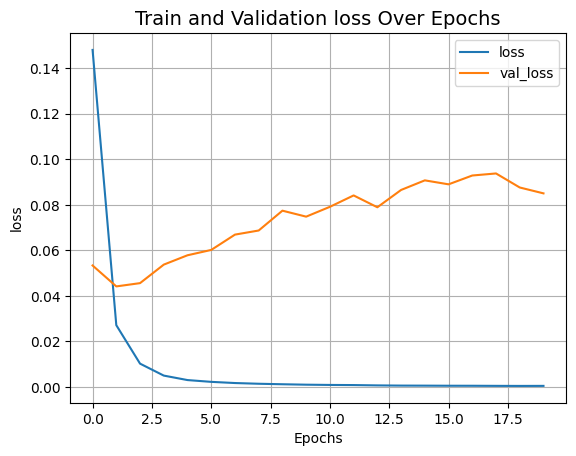

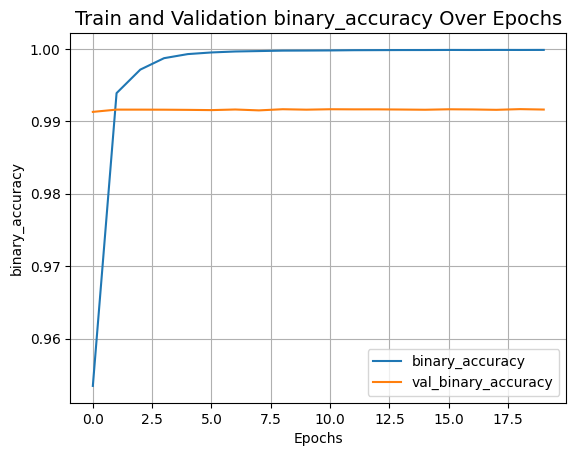

In [33]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("binary_accuracy")

In [35]:
_, binary_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(binary_acc * 100, 2)}%.")

11/11 [==============================] - 0s 14ms/step - loss: 0.0871 - binary_accuracy: 0.9917
Categorical accuracy on the test set: 99.17%.


## Saving Model

In [36]:
path = '/content/drive/MyDrive/Colab Notebooks/ml-stuff/model/services/'

In [37]:
!mkdir -p saved_model
shallow_mlp_model.save(path + 'worker/browse_project_model/my_model')

## Load Model

In [38]:
browse_project_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/ml-stuff/model/services/worker/browse_project_model/my_model')

## Prediction

In [40]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, browse_project_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(services_test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Text: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_5_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:5]
    print(f"Predicted Label(s): ({', '.join([label for label in top_5_labels])})")
    print(" ")

4/4 [==============================] - 0s 5ms/step
Text: b'halo perkenalkan nama saya topan hidayat saya membuka jasa pengetikan dokumen skripsi tugas kuliah dan lain lain dengan harga fix rp 3000 per lembar dengan ukuran kertas normal a4 dengan pengerjaan dalam waktu secepatnya'
Label(s): ['Data Entry' 'Retyping']
Predicted Label(s): (Data Entry, Retyping, Writing, Microsoft Word, Microsoft Office)
 
Text: b'halo saya menawarkan jasa pembuatan transkrip verbatim wawancara untuk kepentingan tugas lgd report dengan format dari anda atau format standard biaya yang dikenakan rp 2 000 permenit untuk durasi dibawah 30 menit rp 50 000 untuk durasi 30 menit dan berlaku kelipatannya lama pengerjaan durasi 2 5 jam adalah 1 hari 2 5 jam pengerjaan paling lama 5 hari'
Label(s): ['Writing' 'Data Entry' 'Transcription']
Predicted Label(s): (Writing, Transcription, Video Editing, Video Production, Microsoft Word)
 
Text: b'saya paham ada banyak produk jasa yang sebenarnya sangat bagus namun tidak te